<a href="https://colab.research.google.com/github/Hsuyeon01/ESAA/blob/main/%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8_(0926_%EA%B3%BC%EC%A0%9C).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 7. 앙상블 학습과 랜덤 포레스트

앙상블 학습 : 일련의 예측기(앙상블)로부터 예측을 수집

- 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련 -> 모든 개별 트리의 예측을 구함 -> 그 중 가장 많은 선택을 받은 클래스를 예측으로 삼음
- 랜덤 포레스트 : 결정 트리의 앙상블


## 7.1 투표 기반 분류기

직접 투표 분류기 : 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것, 다수결 투표로 정해지는 분류기

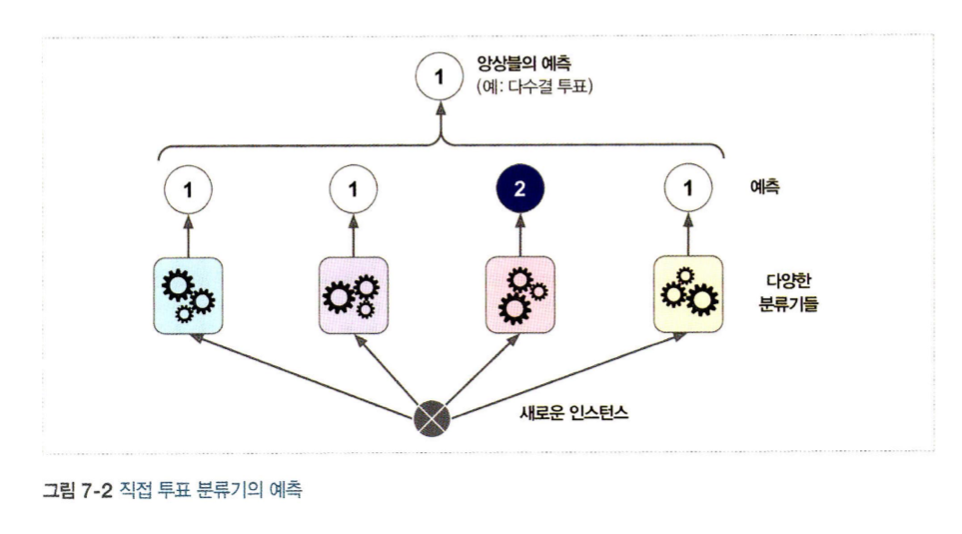

- 각 분류기가 약한 학습기일지라도 충분하게 많고 다양하다면 앙상블은 **강한 학습기**가 될 수 있음
  - 모든 분류기가 완벽하게 독립적이고 오차에 상관관계가 없어야 함 -> 같은 데이터로 훈련시키기 때문에 가정이 맞지 않음

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [3]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf,  svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.896
VotingClassifier 0.904


- 투표 기반 분류기가 다른 개별 분류기보다 성능이 더 좋음

간접 투표 : 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스 예측

- 확률이 높은 투표에 비중을 더 두기 대문에 직접 투표 방식보다 성능이 높음
- voting = 'hard' 대신 voting = 'soft' 사용
- SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability = 'True'로 지정해야 함

In [4]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [5]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


정확도가 더 높음

## 7.2 배깅과 페이스팅

- 배깅 : 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅 : 훈련 세트에서 중복을 허용하지 않고 샘플링하는 방식

-> 배깅과 페이스팅에서는 같은 훈련 샘플을 여러 개의 예측기에 걸쳐 사용할 수 있음

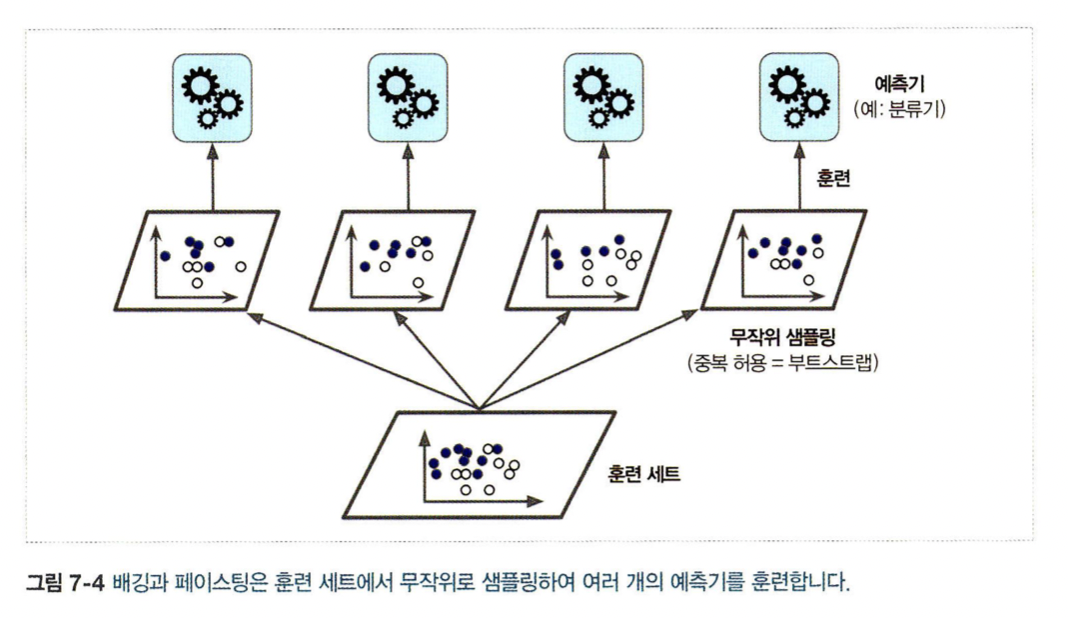

- 수집함수
  - 분류일 때는 통계적 최빈값
  - 회귀일 때는 평균
- 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있지만 수집 함수를 통과하면 편향과 분산이 모두 감소
- 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 때와 비교해 편향은 비슷하지만 분산은 줄어듦
- 예측기는 모두 동시에 다른 CPU 코어나 서버에서 병렬로 학습시킬 수 있음, 예측도 병렬도 수행 가능

### 7.2.1 사이킷런의 배깅과 페이스팅

In [6]:
# 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, 
    bootstrap=True, # 중복허용, 페이스팅을 사용하려면 bootstrap = False로 지정하면 됨
    n_jobs=-1 # n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정 (-1로 지정하면 가용한 모든 코어 사용)
) 
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

- 부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높음, 그러나 다양성이 증가하여 예측기들의 상관관계를 줄이므로 앙상블의 분산은 감소
- 전반적으로 배깅이 더 나은 모델을 만들기 때문에 더 선호

### 7.2.2 oob 평가

- BaggingClassifier는 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택 -> 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미
- oob 샘플 : 선택되지 않은 훈련 샘플의 나머지 37% (예측기마다 다름)
  - 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻음

In [7]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1,
    oob_score = True # oob 평가를 자동으로 수행
)

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9226666666666666

In [8]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [9]:
bag_clf.oob_decision_function_ # 결정 함수의 값, 각 훈련 샘플의 클래스 확률 반환

array([[0.31524548, 0.68475452],
       [0.35532995, 0.64467005],
       [1.        , 0.        ],
       [0.00808625, 0.99191375],
       [0.01591512, 0.98408488],
       [0.13513514, 0.86486486],
       [0.40909091, 0.59090909],
       [0.0855615 , 0.9144385 ],
       [0.94117647, 0.05882353],
       [0.83646113, 0.16353887],
       [0.55759162, 0.44240838],
       [0.04871795, 0.95128205],
       [0.74193548, 0.25806452],
       [0.87775061, 0.12224939],
       [0.91968912, 0.08031088],
       [0.08311688, 0.91688312],
       [0.02356021, 0.97643979],
       [0.92736077, 0.07263923],
       [0.63989637, 0.36010363],
       [0.94680851, 0.05319149],
       [0.04188482, 0.95811518],
       [0.2689295 , 0.7310705 ],
       [0.8806366 , 0.1193634 ],
       [0.99224806, 0.00775194],
       [0.95287958, 0.04712042],
       [0.00258398, 0.99741602],
       [0.94488189, 0.05511811],
       [0.99746835, 0.00253165],
       [0.01846966, 0.98153034],
       [0.76041667, 0.23958333],
       [0.

## 7.3 랜덤 패치와 랜덤 서브스페이스

- 랜덤 패치 방식 : 훈련 특성과 샘플을 모두 샘플링하는 것
- 랜덤 서브스페이스 방식 : 훈련 샘플을 모두 사용하고 (bootstrap=False, max_samples=1.0) 특성은 샘플링 (bootstrap_features=True, max_samples는 1.0보다 작게
- 특성 샘플링은 더 다양한 예측기를 만들어 편향을 늘리는 대신 분산을 낮춤

## 7.4 랜덤 포레스트

일반적으로 배깅(또는 페이스팅)을 적용한 결정 트리의 앙상블

In [10]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

### 7.4.1 엑스트라 트리

- 익스트림 랜덤 트리 앙상블 (또는 엑스트라 트리) : 극단적으로 무작위한 트리의 랜덤 포레스트
  - 편향이 늘어나지만 대신 분산을 낮춤
  - 일반적인 랜덤 포레스트보다 빠름
- 사이킷런의 ExtraTreeClassifier 사용

### 7.4.2 특성 중요도

- 랜덤 포레스트의 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것
  - 사이킷런은 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도 측정 -> 가중치 평균, 각 노드의 가중치는 연관된 훈련 샘플 수와 같음
- 사이킷런은 훈련이 끝난 뒤 특성마다 자동으로 점수를 계산하고 중요도의 전체 합이 1이 되도록 정규화

In [11]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'],iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.09858715428663913
sepal width (cm) 0.022917860582437093
petal length (cm) 0.4435801395599548
petal width (cm) 0.43491484557096893


특성을 선택할 때 어떤 특성이 중요한지 빠르게 확인할 수 있음

## 7.5 부스팅

부스팅 : 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법

- 앞의 모델을 보완해나가면서 일련의 예측기를 학습

### 7.5.1 에이다부스트



- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 높임 -> 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞췌지게 됨 (가중치 업데이트)
- 경사하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가함
- 훈련을 마치면 배깅이나 페이스팅과 비슷한 방식으로 예측을 만드나 가중치가 적용된 훈련 세트의 전반적인 정확도에 따라 예측기마다 다른 가중치가 적용됨

In [12]:
# AdaBoostClassifier 기본 추정기
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레디언트 부스팅

- 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하지만 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 잔여 오차에 새로운 예측기를 학습시킴

In [13]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [14]:
# 첫번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(max_depth=2)

In [15]:
# 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(max_depth=2)

In [16]:
import numpy as np
X_new = np.array([[0.8, 0.5]])

In [17]:
# 모든 트리의 예측 더하기
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

- 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아짐


In [18]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

- learning_rate 매개변수가 각 트리의 기여 정도를 조절
  - 0.1처럼 낮게 설정하면 앙상블의 훈련 세트에 학습시키기 위해 많은 트리가 필요하지만 예측의 성능은 좋아짐 -> 축소라 부르는 규제방법
- 최적의 트리 수를 찾기 위해 조기 종료 기법 사용
  - 훈련의 각 단계에서 앙상블에 의해 만들어진 예측기를 순회하는 반복자를 반환
  - 각 훈련 단계에서 검증 오차를 측정
  - 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킴

In [19]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred) for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=67)

In [20]:
# 실제로 훈련을 중지하는 방법으로 조기 종료를 구할 수 있음
# warm_start = True -> fit() 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해줌
# 연속해서 5번의 반복동안 검증 오차가 향상되지 않으면 훈련을 멈춤

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1,120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up=0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break # 조기종료

- 확률적 그레디언트 부스팅 : 각 트리가 훈련될 때 사용할 훈련 샘플의 비율 지정
  - subsample 
  - 편향이 높아지는 대신 분산이 낮아짐, 훈련 속도 높임
- XGBoost : 최적화된 그레디언트 부스팅 (익스트림 그레디언트 부스팅)
  - 빠른 정확도, 확장성, 이식성

In [21]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

[08:38:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [22]:
# 자동 조기 종료 기능 제공
xgb_reg.fit(X_train, y_train,
            eval_set=[(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[08:39:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:0.467473
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.438659
[2]	validation_0-rmse:0.414127
[3]	validation_0-rmse:0.393275
[4]	validation_0-rmse:0.375215
[5]	validation_0-rmse:0.360019
[6]	validation_0-rmse:0.347074
[7]	validation_0-rmse:0.335853
[8]	validation_0-rmse:0.323406
[9]	validation_0-rmse:0.317199
[10]	validation_0-rmse:0.30714
[11]	validation_0-rmse:0.302516
[12]	validation_0-rmse:0.295497
[13]	validation_0-rmse:0.28888
[14]	validation_0-rmse:0.286966
[15]	validation_0-rmse:0.280688
[16]	validation_0-rmse:0.279102
[17]	validation_0-rmse:0.272768
[18]	validation_0-rmse:0.270922
[19]	validation_0-rmse:0.266651
[20]	validation_0-rmse:0.265726
[21]	validation_0-rmse:0.261239
[22]	validation_0-rmse:0.260208
[23]	validation_0-rmse:0.257125
[24]	validation_0-rmse:0.256684
[25]	validation_0-rms

## 7.6 스태킹

- 앙상블에 속한 모든 예측기의 예측을 취합하는 간단한 함수를 사용하는 대신 취합하는 모델을 훈련
- 블렌더, 메타학습기 : 최종 예측을 만드는 마지막 예측기
  - 블렌더를 학습시키는 일반적인 방법 -> 홀드 아웃 세트를 사용
  - 훈련 세트를 두 개의 서브셋으로 나눈 다음 첫 번째 서브셋은 첫 번째 레이어의 예측을 훈련시키기 위해 사용, 첫 번재 레이어의 예측기를 사용해 두 번째 세트에 대한 예측을 만듦
  - 사이킷런은 스태킹을 직접 지원하지 않음